# Scenario 4: Insight into mechanism by modelling 
Dataset provided by Sandile Ngubane (Department of Biotechnology and Food Technology, Durban University of Technology, Durban 4000, South Africa)  
  
This Jupyter Notebook accompanies the fourth scenario of the paper: EnzymeML at work: seamless data flow and modelling of enzymatic data.  
In this scenario the time-course data from an EnzymeML document is analysed visually and with kinetic modelling.

## Imports <a class="anchor" name="Imports"></a>
All necessary Python packages are installed and imported.  
If you run this notebook with Binder you don't have to install anything, Binder takes care of this.  
In order to run on google Colaboratory (Colab), PyEnzyme will be installed and the dataset is loaded from GitHub. This is done in the first Code Cell.  
To run the notebook on Colab click on the badge:  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EnzymeML/Lauterbach_2021/blob/main/Scenario4/InsightIntoMechanismByModelling.ipynb)  
If you run this notebook local make sure you have all Packages installed and the dataset in the same directory as the notebook.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+git://github.com/EnzymeML/PyEnzyme.git@feature/experiment-class
    !pip install lmfit
    !wget https://github.com/EnzymeML/Lauterbach_2021/raw/main/Scenario4/ABTS_Measurement_Ngubane.omex
else:
    print('Not running on Colab.')

Not running on Colab.


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats
from scipy.integrate import odeint
from lmfit import minimize, Parameters, report_fit

from pyenzyme.enzymeml.core import EnzymeMLDocument, Protein, EnzymeReaction
from pyenzyme.enzymeml.models import KineticModel, KineticParameter

## Reading EnzymeML with PyEnzyme software <a class="anchor" name="ReadingEnzymeML"></a>
In order to read the EnzymeML document and access its content with the PyEnzyme software the file path is defined.  
When running the next code cell the EnzymeML document is saved in the `enzmlDoc` variable and an overview is printed below.

In [3]:
path = 'ABTS_Measurement_Ngubane.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLDocument.fromFile(path)
else:
    raise FileNotFoundError(
        f'Couldnt find file at {path}.'
    )

enzmlDoc

ABTS_Measurement
>>> Reactants
	ID: s0 	 Name: 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulphonic acid)
	ID: s1 	 Name: oxygen
	ID: s2 	 Name: 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulphonic acid) radicals
	ID: s3 	 Name: H2O
>>> Proteins
	ID: p0 	 Name: laccase 2 (lap2)
	ID: p1 	 Name: laccase 2 (lap2) inactive
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Oxidation
	ID: r1 	 Name: Enzyme inactivation

The overview shows which reactant corresponds to which id.  
Each measurement consists of 3 reactants and one protein (p0).
In this case all 9 measurements were carried out under identical conditions and with varying initial concentrations of the substrate (s0). All concentration units are identical so no conversion is needed later on.     
Next, one measurement is exemplarily examined. 

In [4]:
# Fetch the measurement
measurement = enzmlDoc.getMeasurement('m0')
measurement.printMeasurementScheme()

>>> Measurement m0: Oxidation 1
    s0 | initial conc: 5.0 umole / l 	| #replicates: 3
    s1 | initial conc: 0.0 umole / l 	| #replicates: 0
    s2 | initial conc: 0.0 umole / l 	| #replicates: 0
    s3 | initial conc: 0.0 umole / l 	| #replicates: 0
    p0 | initial conc: 0.93 umole / l 	| #replicates: 0


The overview of the measurement shows that three replicates were measured for the substrate s0.

## Data preparation <a class="anchor" name="DataPreparation"></a>
In order to visualise and model the data, it first has to be extracted and prepared.  
All relevant data such as the initial concentrations and time-course data are extracted.

In [5]:
# define colors for time-course visualisation
colors9 = ['#252525','#999999','#f781bf','#984ea3','#ff7f00','#ffff33','#a65628','#4daf4a','#377eb8']
colors = []
# Substrate:
s0_init_conc = []
measured_data = []
# Protein:
p0_init_conc = []

# time and units
measurement = enzmlDoc.getMeasurement('m0')
time = measurement.global_time
time_unit = measurement.global_time_unit
conc_unit = ''

# go through all measurements:
for i, measurement in enumerate(enzmlDoc.measurement_dict.values()):
    
    # get replicates with time course data:
    reactant = measurement.getReactant('s0')
    conc_unit = reactant.unit
        
    for replicate in reactant.replicates:
        
        # Protein:
        p0_init_conc.append(measurement.getProtein('p0').init_conc)
        
        # Substrate:
        s0_init_conc.append(measurement.getReactant('s0').init_conc)
        measured_data.append(replicate.data)
        
        colors.append(colors9[i])

measured_data = np.array(measured_data)
p0_init_conc = np.array(p0_init_conc)
s0_init_conc = np.array(s0_init_conc)
time = np.array(time)

## Visualisation of time-course data <a class="anchor" name="Visualisation"></a>
All time-course data is visualised with the Python library matplotlib.  
In order to save the figures as svg uncomment the `plt.savefig(...)` code lines. 

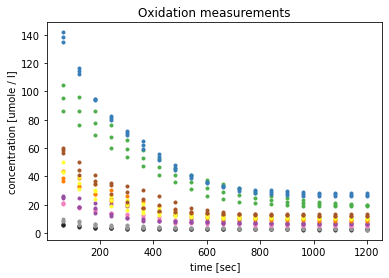

In [6]:
# get reaction name for the title of the visualisation
reaction_name = enzmlDoc.getReaction('r0').name
# plot time course data with matplotlib
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    ax.plot(time, measured_data[i, :],'o', ms=3, color=colors[i])
plt.title(reaction_name+' measurements')
xlabel = f"{'time'} [{time_unit}]"
ylabel = f"{'concentration'} [{conc_unit}]"
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

## Kinetic modelling and parameter estimation <a class="anchor" name="KineticModelling"></a>
In order to model the data and perform parameter fitting, the kinetic equations for the models are defined as Python functions, along with a function to calculate the residual between the models and the measured data.  
In the following cell 3 different models are defined.  
First the irreversible Michaelis-Menten kinetic. 
Then, an extension of Michaelis-Menten with time-dependent enzyme inactivation. 
And last a Michaelis-Menten kinetic with substrate-dependent enzyme inactivation.  
Additional all kinetics contain a bias parameter, which will either be fixed to 0 or an additional variable parameter for the model fitting.  
The cell is followed by the code cell containing the computation of the residual.

In [7]:
def irreversible_Michaelis_Menten(w, t, params):
    '''
    Differential equation of Michaelis-Menten model
    Arguments:
        w: vector of state variables: w = [c_S, c_E]
        t: time
        params: parameters object from lmfit
    '''
    c_S, c_E = w
    
    k_cat = params['k_cat'].value
    K_M = params['K_M'].value
    bias = params['bias'].value
    
    dc_S = -k_cat*c_E*(c_S-bias)/(K_M+c_S-bias) # dc_S/dt
    dc_E = 0
    
    return (dc_S, dc_E)

def menten_with_enzyme_inactivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [c_S, c_E]
        t: time
        params: parameters object from lmfit
    '''
    c_S, c_E = w
    
    k_cat = params['k_cat'].value
    K_M = params['K_M'].value
    k_i = params['k_i'].value
    bias = params['bias'].value
    
    dc_S = -k_cat*c_E*(c_S-bias)/(K_M+c_S-bias)
    dc_E = -k_i*c_E
    
    return (dc_S, dc_E)

def menten_with_substrate_dependent_enzyme_inactivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [c_S, c_E]
        t: time
        params: parameters object from lmfit
    '''
    c_S, c_E = w
    
    k_cat = params['k_cat'].value
    K_M = params['K_M'].value
    k_i = params['k_i'].value
    bias = params['bias'].value
    
    dc_S = -k_cat*c_E*(c_S-bias)/(K_M+c_S-bias)
    dc_E = -k_i*c_E*c_S
    
    return (dc_S, dc_E)

In [8]:
def residual(params, t, data, w, f):
    '''
    Calculates residual between measured data and modelled data

    Args:
        params: parameters object from lmfit
        t: time
        data: measured data
        w: vector of state variables [c_S, c_E]
        f: ODEs
    '''
    bias = np.array([params['bias'].value,0])
    w = np.add(w, bias)

    ndata = data.shape[0]
    residual = 0.0*data[:]
    for i in range(ndata):
        model = odeint(f, w[i], t, args=(params,))
        s_model = model[:,0]
        residual[i,:]=data[i,:]-s_model
    return residual.flatten()

### Initialising parameters <a class="anchor" name="ParameterInit"></a>
The Python library lmfit provides a parameter object to initialise the parameters before the fit.

In [9]:
slopes = []
for i in range(measured_data.shape[0]):
    slope, intercept, r, p, se = stats.linregress(time[0:2], measured_data[i][0:2])
    slopes.append(abs(slope))
v_max = np.max(slopes)
c_E = p0_init_conc[0]
k_cat = v_max/c_E
K_M = np.max(s0_init_conc)

In [10]:
# Parameters for irreversible Michaelis-Menten without bias
params_MM = Parameters()
params_MM.add('k_cat', value=k_cat, min=0.0001, max=1000)
params_MM.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_MM.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with bias
params_MM_with_bias = Parameters()
params_MM_with_bias.add('k_cat', value=k_cat, min=0.0001, max=1000)
params_MM_with_bias.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_MM_with_bias.add('bias', value=0.1, min=0.0001, max=np.max(measured_data)*0.5)

In [11]:
# Parameters for Michaelis-Menten with time-dependent enzyme inactivation
params_time_dep_inactivation = Parameters()
params_time_dep_inactivation.add('k_i', value=0.5, min=0.00000001, max=np.max(measured_data))
params_time_dep_inactivation.add('k_cat', value=k_cat, min=0.0001, max=100)
params_time_dep_inactivation.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_time_dep_inactivation.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with time-dependent enzyme inactivation and bias
params_time_dep_inactivation_with_bias = Parameters()
params_time_dep_inactivation_with_bias.add('k_i', value=0.5, min=0.00000001, max=np.max(measured_data))
params_time_dep_inactivation_with_bias.add('k_cat', value=k_cat, min=0.0001, max=100)
params_time_dep_inactivation_with_bias.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_time_dep_inactivation_with_bias.add('bias', value=0, min=-0.00001, max=np.max(measured_data)*0.5)

In [12]:
# Parameters for Michaelis-Menten with substrate-dependent enzyme inactivation
params_sub_dep_inactivation = Parameters()
params_sub_dep_inactivation.add('k_i', value=0.5, min=0.00000001, max=np.max(measured_data))
params_sub_dep_inactivation.add('k_cat', value=k_cat, min=0.0001, max=100)
params_sub_dep_inactivation.add('K_M', value=K_M, min=0.0001, max=np.max(measured_data)*100)
params_sub_dep_inactivation.add('bias', value=0, vary=False)

# Parameters for Michaelis-Menten with substrate-dependent enzyme inactivation and bias
params_sub_dep_inactivation_with_bias = Parameters()
params_sub_dep_inactivation_with_bias.add('k_i', value=1.4, min=0.00000001, max=np.max(measured_data))
params_sub_dep_inactivation_with_bias.add('k_cat', value=50, min=0.0001, max=100)
params_sub_dep_inactivation_with_bias.add('K_M', value=10000, min=0.0001, max=np.max(measured_data)*100)
params_sub_dep_inactivation_with_bias.add('bias', value=2, min=0.00001, max=np.max(measured_data)*0.5)

### Model 1: Parameter fitting and results <a class="anchor" name="Model1"></a>
In the next cell the parameters for model 1 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [13]:
results_dict = {}
# model 1: irreversible Michaelis-Menten
w = np.append(s0_init_conc, p0_init_conc).reshape((2,s0_init_conc.shape[0]))
w = np.transpose(w)
result_MM = minimize(residual, params_MM, args=(time, measured_data, w, irreversible_Michaelis_Menten), method='leastsq')
results_dict['irreversible Michaelis-Menten'] = result_MM

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 540
    # variables        = 2
    chi-square         = 30704.2667
    reduced chi-square = 57.0711277
    Akaike info crit   = 2185.91739
    Bayesian info crit = 2194.50053
[[Variables]]
    k_cat:  39.4469476 +/- 117.894199 (298.87%) (init = 0.4469534)
    K_M:    14170.9697 +/- 517252.132 (3650.08%) (init = 150)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M) = 1.000


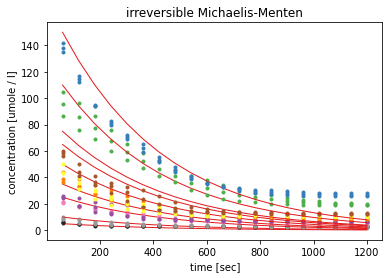

In [14]:
result = result_MM
report_fit(result)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted1 = odeint(irreversible_Michaelis_Menten, w[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted1[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('irreversible Michaelis-Menten')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model1.svg', bbox_inches='tight')
plt.show()

### Model 2: Parameter fitting and results <a class="anchor" name="Model2"></a>
In the next cell the parameters for model 2 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [15]:
# model 2: Michaelis-Menten with bias
result_MM_with_bias = minimize(residual, params_MM_with_bias, args=(time, measured_data, w, irreversible_Michaelis_Menten), method='leastsq')
results_dict['irrev. Michaelis-Menten with bias'] = result_MM_with_bias

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8000
    # data points      = 540
    # variables        = 3
    chi-square         = 30832.9664
    reduced chi-square = 57.4170697
    Akaike info crit   = 2190.17612
    Bayesian info crit = 2203.05083
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k_cat:  17.1672221 (init = 0.4469534)
    K_M:    6131.71619 (init = 150)
    bias:   2.8195e-04 (init = 0.1)


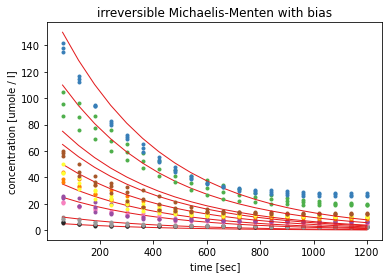

In [16]:
result = result_MM_with_bias
report_fit(result)
# add bias for visualisation
bias = np.array([result.params['bias'].value,0])
w2 = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted2 = odeint(irreversible_Michaelis_Menten, w2[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted2[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('irreversible Michaelis-Menten with bias')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model2.svg', bbox_inches='tight')
plt.show()

### Model 3: Parameter fitting and results <a class="anchor" name="Model3"></a>
In the next cell the parameters for model 3 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [17]:
# model 3: Michaelis-Menten with time-dependent enzyme inactivation
result_time_dep_inactivation = minimize(residual, params_time_dep_inactivation, args=(time, measured_data, w, menten_with_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten time-dep. enzyme inactivation'] = result_time_dep_inactivation

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 540
    # variables        = 3
    chi-square         = 12133.7067
    reduced chi-square = 22.5953569
    Akaike info crit   = 1686.57363
    Bayesian info crit = 1699.44834
[[Variables]]
    k_i:    0.00261930 +/- 1.0924e-04 (4.17%) (init = 0.5)
    k_cat:  2.58931715 +/- 0.44205883 (17.07%) (init = 0.4469534)
    K_M:    440.900638 +/- 89.9365300 (20.40%) (init = 150)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M) = 0.991
    C(k_i, K_M)   = -0.373
    C(k_i, k_cat) = -0.255


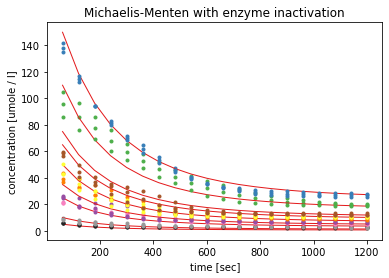

In [18]:
result = result_time_dep_inactivation
report_fit(result)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted3 = odeint(menten_with_enzyme_inactivation, w[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted3[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with enzyme inactivation')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model3.svg', bbox_inches='tight')
plt.show()

### Model 4: Parameter fitting and results <a class="anchor" name="Model4"></a>
In the next cell the parameters for model 4 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [19]:
# model 4: Michaelis-Menten with time-dependent enzyme inactivation and bias
result_time_dep_inactivation_with_bias = minimize(residual, params_time_dep_inactivation_with_bias, args=(time, measured_data, w, menten_with_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten time-dep. enzyme inactivation and bias'] = result_time_dep_inactivation_with_bias


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 956
    # data points      = 540
    # variables        = 4
    chi-square         = 12133.7185
    reduced chi-square = 22.6375346
    Akaike info crit   = 1688.57416
    Bayesian info crit = 1705.74044
[[Variables]]
    k_i:    0.00261840 +/- 1.1520e-04 (4.40%) (init = 0.5)
    k_cat:  2.60032215 +/- 0.56090633 (21.57%) (init = 0.4469534)
    K_M:    443.147700 +/- 118.705923 (26.79%) (init = 150)
    bias:  -9.6876e-06 +/- 0.42307715 (4367214.48%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M)  = 0.993
    C(K_M, bias)   = 0.644
    C(k_cat, bias) = 0.605
    C(k_i, K_M)    = -0.474
    C(k_i, k_cat)  = -0.384
    C(k_i, bias)   = -0.315


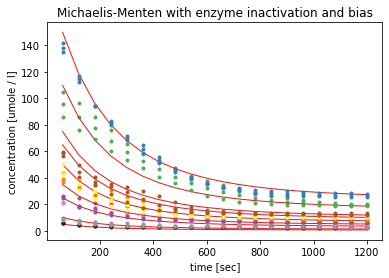

In [20]:
result = result_time_dep_inactivation_with_bias
report_fit(result)
# add bias for visualisation
bias = np.array([result.params['bias'].value,0])
w4 = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted4 = odeint(menten_with_enzyme_inactivation, w4[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted4[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with enzyme inactivation and bias')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model4.svg', bbox_inches='tight')
plt.show()

### Model 5: Parameter fitting and results <a class="anchor" name="Model5"></a>
In the next cell the parameters for model 5 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [21]:
# model 5: Michaelis-Menten with substrate-dependent enzyme inactivation
result_substrate_dep_inactivation = minimize(residual, params_sub_dep_inactivation, args=(time, measured_data, w, menten_with_substrate_dependent_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten sub.-dep. enzyme inactivation'] = result_substrate_dep_inactivation

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 199
    # data points      = 540
    # variables        = 3
    chi-square         = 20223.7690
    reduced chi-square = 37.6606500
    Akaike info crit   = 1962.44416
    Bayesian info crit = 1975.31887
[[Variables]]
    k_i:    2.3797e-05 +/- 1.5642e-06 (6.57%) (init = 0.5)
    k_cat:  59.8629358 +/- 370.173447 (618.37%) (init = 0.4469534)
    K_M:    14170.9999 +/- 3263.63409 (23.03%) (init = 150)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M) = 1.000
    C(k_i, k_cat) = 0.375
    C(k_i, K_M)   = 0.371


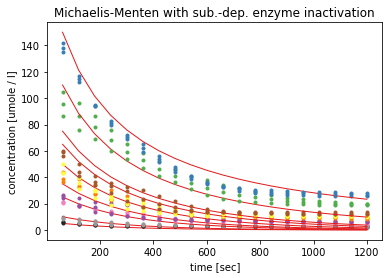

In [22]:
result = result_substrate_dep_inactivation
report_fit(result)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted5 = odeint(menten_with_substrate_dependent_enzyme_inactivation, w[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted5[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with sub.-dep. enzyme inactivation')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model5.svg', bbox_inches='tight')
plt.show()

### Model 6: Parameter fitting and results <a class="anchor" name="Model6"></a>
In the next cell the parameters for model 6 are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [23]:
# model 6: Michaelis-Menten with substrate-dependent enzyme inactivation and bias
result_substrate_dep_inactivation_with_bias = minimize(residual, params_sub_dep_inactivation_with_bias, args=(time, measured_data, w, menten_with_substrate_dependent_enzyme_inactivation), method='leastsq')
results_dict['Michaelis-Menten sub.-dep. enzyme inactivation and bias'] = result_substrate_dep_inactivation_with_bias

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 566
    # data points      = 540
    # variables        = 4
    chi-square         = 18456.7991
    reduced chi-square = 34.4343268
    Akaike info crit   = 1915.07424
    Bayesian info crit = 1932.24051
[[Variables]]
    k_i:    3.0232e-05 +/- 1.7165e-06 (5.68%) (init = 1.4)
    k_cat:  73.3094145 +/- 509.836660 (695.46%) (init = 50)
    K_M:    14170.9898 +/- 97740.3501 (689.72%) (init = 10000)
    bias:   2.88973569 +/- 0.42397948 (14.67%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M)  = 1.000
    C(K_M, bias)   = -0.502
    C(k_cat, bias) = -0.499
    C(k_i, bias)   = 0.251
    C(k_i, k_cat)  = 0.175
    C(k_i, K_M)    = 0.170


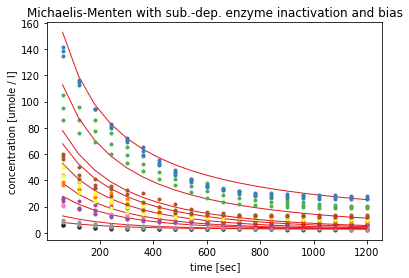

In [24]:
result = result_substrate_dep_inactivation_with_bias
report_fit(result)
# add bias for visualisation
bias = np.array([result.params['bias'].value,0])
w6 = np.add(w, bias)
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    data_fitted6 = odeint(menten_with_substrate_dependent_enzyme_inactivation, w6[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, color=colors[i])
    if (i%3)==0:
        ax.plot(time, data_fitted6[:,0], '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('Michaelis-Menten with sub.-dep. enzyme inactivation and bias')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
# save as svg
#plt.savefig('model6.svg', bbox_inches='tight')
plt.show()

### Table with estimated parameters for all models <a class="anchor" name="TableModels"></a>

In [25]:
models_dataframe = pd.DataFrame()
for model_name, model_result in results_dict.items():
    for parameter_name, parameter_value in model_result.params.valuesdict().items():
        models_dataframe.loc[parameter_name,model_name] = round(parameter_value,1) if parameter_value > 1  else round(parameter_value,4)
models_dataframe

,irreversible Michaelis-Menten,irrev. Michaelis-Menten with bias,Michaelis-Menten time-dep. enzyme inactivation,Michaelis-Menten time-dep. enzyme inactivation and bias,Michaelis-Menten sub.-dep. enzyme inactivation,Michaelis-Menten sub.-dep. enzyme inactivation and bias
k_cat,39.4,17.2000,2.6000,2.6000,59.9,73.3
K_M,14171.0,6131.7000,440.9000,443.1000,14171.0,14171.0
bias,0.0,0.0003,0.0000,-0.0000,0.0,2.9
k_i,NaN,NaN,0.0026,0.0026,0.0,0.0


## Add model with estimated parameters to EnzymeML <a class="anchor" name="AddModel"></a>
Since we modelled two coupled differential equations we need to define a second reaction. In SBML each reaction can only be described by a single equation model. For this we will defined the reaction of the enzyme inactivation, with the active enzyme as substrate and the inactive enzyme as product.  
Therefore the inactive enzyme is defined in the next code cell.

In [26]:
# Copy the old Protein
params = enzmlDoc.getProtein('p0').dict()

# Create new Protein object, modify and add it
protein2 = Protein(**params)
protein2.name += " inactive"
protein2.init_conc = 0.0
protein2.constant = False

protein2_id = enzmlDoc.addProtein(protein2)

Now the second reaction is defined.

In [27]:
# Copy old reaction
params = enzmlDoc.getReaction('r0').dict()

# Create new Reaction
reaction2 = EnzymeReaction(**params)
reaction2.name = "Enzyme inactivation"
reaction2.reversible = True

# Add reaction elements
reaction2.addEduct('p0', 1.0, enzmlDoc)
reaction2.addProduct(protein2_id, 1.0, enzmlDoc)

# Finally, add it to the document
reaction2_id = enzmlDoc.addReaction(reaction2)

Next the kinetic model is defined with the differential equations and the estimated parameters.

In [28]:
equation_dsdt = "- k_cat * p0 * (s0 - bias) / (K_M + s0 - bias)"
equation_dedt = "- k_i * p0"

# parameters:
kcat_value = round(result_time_dep_inactivation_with_bias.params['k_cat'].value,2)
kcat_unit = f"1 / {time_unit}"

bias_value = round(result_time_dep_inactivation_with_bias.params['bias'].value, 2)
bias_unit = conc_unit

km_value = round(result_time_dep_inactivation_with_bias.params['K_M'].value,1)
km_unit = conc_unit

ki_value = round(result_time_dep_inactivation_with_bias.params['k_i'].value,4)
ki_unit = f"1 / {time_unit}"

# Create a model for the first reaction
k_cat = KineticParameter(name="k_cat", value=kcat_value, unit=kcat_unit)
k_m = KineticParameter(name="K_M", value=km_value, unit=km_unit)
bias = KineticParameter(name="bias", value=bias_value, unit=bias_unit)

kineticModel1 = KineticModel(
    name="Michaelis Menten with bias",
    equation=equation_dsdt,
    parameters=[k_cat, k_m, bias],
    enzmldoc=enzmlDoc
)

# Create model for the second reaction
k_i = KineticParameter(name="k_i", value=ki_value, unit=ki_unit)

kineticModel2 = KineticModel(
    name = "Enzyme inactivation",
    equation = equation_dedt, 
    parameters = [k_i],
    enzmldoc = enzmlDoc)

Finally the kinetic model is added to the reactions.

In [29]:
enzmlDoc.getReaction('r0').setModel(kineticModel1, enzmlDoc)
enzmlDoc.getReaction('r1').setModel(kineticModel2, enzmlDoc)

In order to write the EnzymeML document uncomment the next code line.

In [30]:
# enzmlDoc.toFile('.')

## Upload to DaRUS <a class="anchor" name="Upload"></a>
Finally, the EnzymeML document is published on DaRUS and written to your current directory.   
In order to publish a dataset to DaRUS you need an API Token.  
If you want to publish set the `publish` variable to `True`. Then you will be asked for your API Token.

In [31]:
publish = False

In [32]:
if publish:
    os.environ["DATAVERSE_URL"] = "https://darus.uni-stuttgart.de"
    os.environ["DATAVERSE_API_TOKEN"] = input('Enter API Token')
    enzmlDoc.uploadToDataverse(dataverseName="enzymeml_at_work")